In [ ]:
import sys
sys.path.append("v2_Assignment_Codes")  # Add the folder to the search path

#load data
from v2_data import get_fixed_data
from PriceProcess import price_model
from WindProcess import wind_model
from utils import generate_time_series,generate_experiment_series

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pyomo.environ import *
from mdp import check_feasibility,sim_MDP_exp, sim_MDP, generate_scenarios

%load_ext autoreload
%autoreload 2


In [2]:
data = get_fixed_data()
T = data['num_timeslots']

In [3]:
# ensure we always use the same time series for all tasks and experiments
prices,winds = generate_experiment_series()

# Task 4

In [4]:
import random

np.random.seed(42)
random.seed(42)

E = 20

## Evaluate the policies 

In [5]:
from mdp import dummy_policy, sim_optimal_in_hindsight, MultiStagePolicy, ADPPolicy, sample_representative_state_pairs, ValueFunction,backward_value_approx


### Dummy Policy

In [6]:
mean_dummy, costs_dummy = sim_MDP(E,dummy_policy,winds,prices)

Simulating MDP: 100%|██████████| 20/20 [00:00<00:00, 11963.22it/s]


### Optimal-in-hindsight solution

In [7]:
mean_oih, costs_oih = sim_optimal_in_hindsight(E,winds,prices)

Simulating OIH: 100%|██████████| 20/20 [00:01<00:00, 14.35it/s]


### Stochastic programming policy for 4 configurations

In [8]:
results = np.zeros((4,E))

multi_state_policy = MultiStagePolicy(L=2,k=99)
_, results[0,:] = sim_MDP(E,multi_state_policy,winds,prices)

multi_state_policy = MultiStagePolicy(L=3,k=8)
_, results[1,:] = sim_MDP(E,multi_state_policy,winds,prices)

multi_state_policy = MultiStagePolicy(L=4,k=3)
_, results[2,:] = sim_MDP(E,multi_state_policy,winds,prices)

multi_state_policy = MultiStagePolicy(L=6,k=2)
_, results[3,:] = sim_MDP(E,multi_state_policy,winds,prices)


Simulating MDP: 100%|██████████| 20/20 [02:51<00:00,  8.56s/it]


### Expected value policy

In [9]:
expected_value_policy = MultiStagePolicy(L=10,k=1)
mean_ev, costs_ev = sim_MDP(E,expected_value_policy,winds,prices)

Simulating MDP: 100%|██████████| 20/20 [00:45<00:00,  2.29s/it]


### ADP Policy

In [10]:
# fit value function
state_pairs = sample_representative_state_pairs(100)
V = backward_value_approx(ValueFunction(data['num_timeslots'],7),state_pairs,40,data)

t=23
5266.4347619495065
243.67883615777993
t=22
5080.415913736451
1.9164840792217648
t=21
4914.796820267952
37.75445653775972
t=20
4754.744785252943
60.13664653337721
t=19
4391.199145181602
91.25228360506804
t=18
4275.063844442626
63.68972431593017
t=17
4020.0466676071524
28.96820033934629
t=16
4397.608923646806
60.72236392336754
t=15
4238.795253393015
46.235308706568006
t=14
4300.926533909131
182.74742914420767
t=13
4477.6173693265555
176.5043705835824
t=12
4930.50337684575
173.48388621773367
t=11
4797.729607614407
230.47343714906054
t=10
5673.99375940437
399.38451817570837
t=9
7478.627631348099
445.7010475177591
t=8
8202.722997481607
381.0353077342853
t=7
11727.01900495629
485.0804072458196
t=6
15865.698873071897
343.36790473143793
t=5
20947.42527265833
422.65004196128024
t=4
31545.89471337627
504.73086262464
t=3
30661.855499753743
342.47964008282287
t=2
43774.786045735134
229.46061570186416
t=1
52269.14806523176
87.14357326589113
t=0
51288.689782078334
1.8191511127631038e-26


In [11]:
# evaluate policy
adp_policy = ADPPolicy(V, data)
mean_adp, costs_adp = sim_MDP(E,adp_policy,winds,prices)

Simulating MDP: 100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


In [12]:
print("Mean Dummy Policy:", mean_dummy)
print("Mean Optimal-in-Hindsight Policy:", mean_oih)
print("Mean Expected Value Policy:", mean_ev)
print("Mean ADP Policy:", mean_adp)

Mean Dummy Policy: 618.4602578980882
Mean Optimal-in-Hindsight Policy: 421.44391346417825
Mean Expected Value Policy: 551.8414796364274
Mean ADP Policy: 521.6075956064336


In [16]:
import os
import pickle

# Ensure the "results" folder exists
os.makedirs("results", exist_ok=True)

# Prepare the data to save
results_data = {
    "mean_dummy": mean_dummy,
    "costs_dummy": costs_dummy,
    "mean_oih": mean_oih,
    "costs_oih": costs_oih,
    "mean_ev": mean_ev,
    "costs_ev": costs_ev,
    "mean_adp": mean_adp,
    "costs_adp": costs_adp,
    "results": results,
    "data": data,
    "prices": prices,
    "winds": winds,
    "state_pairs": state_pairs
}

# Save the data to a file
with open("results/results_data.pkl", "wb") as file:
    pickle.dump(results_data, file)

print("Results saved to 'results/results_data.pkl'")

Results saved to 'results/results_data.pkl'


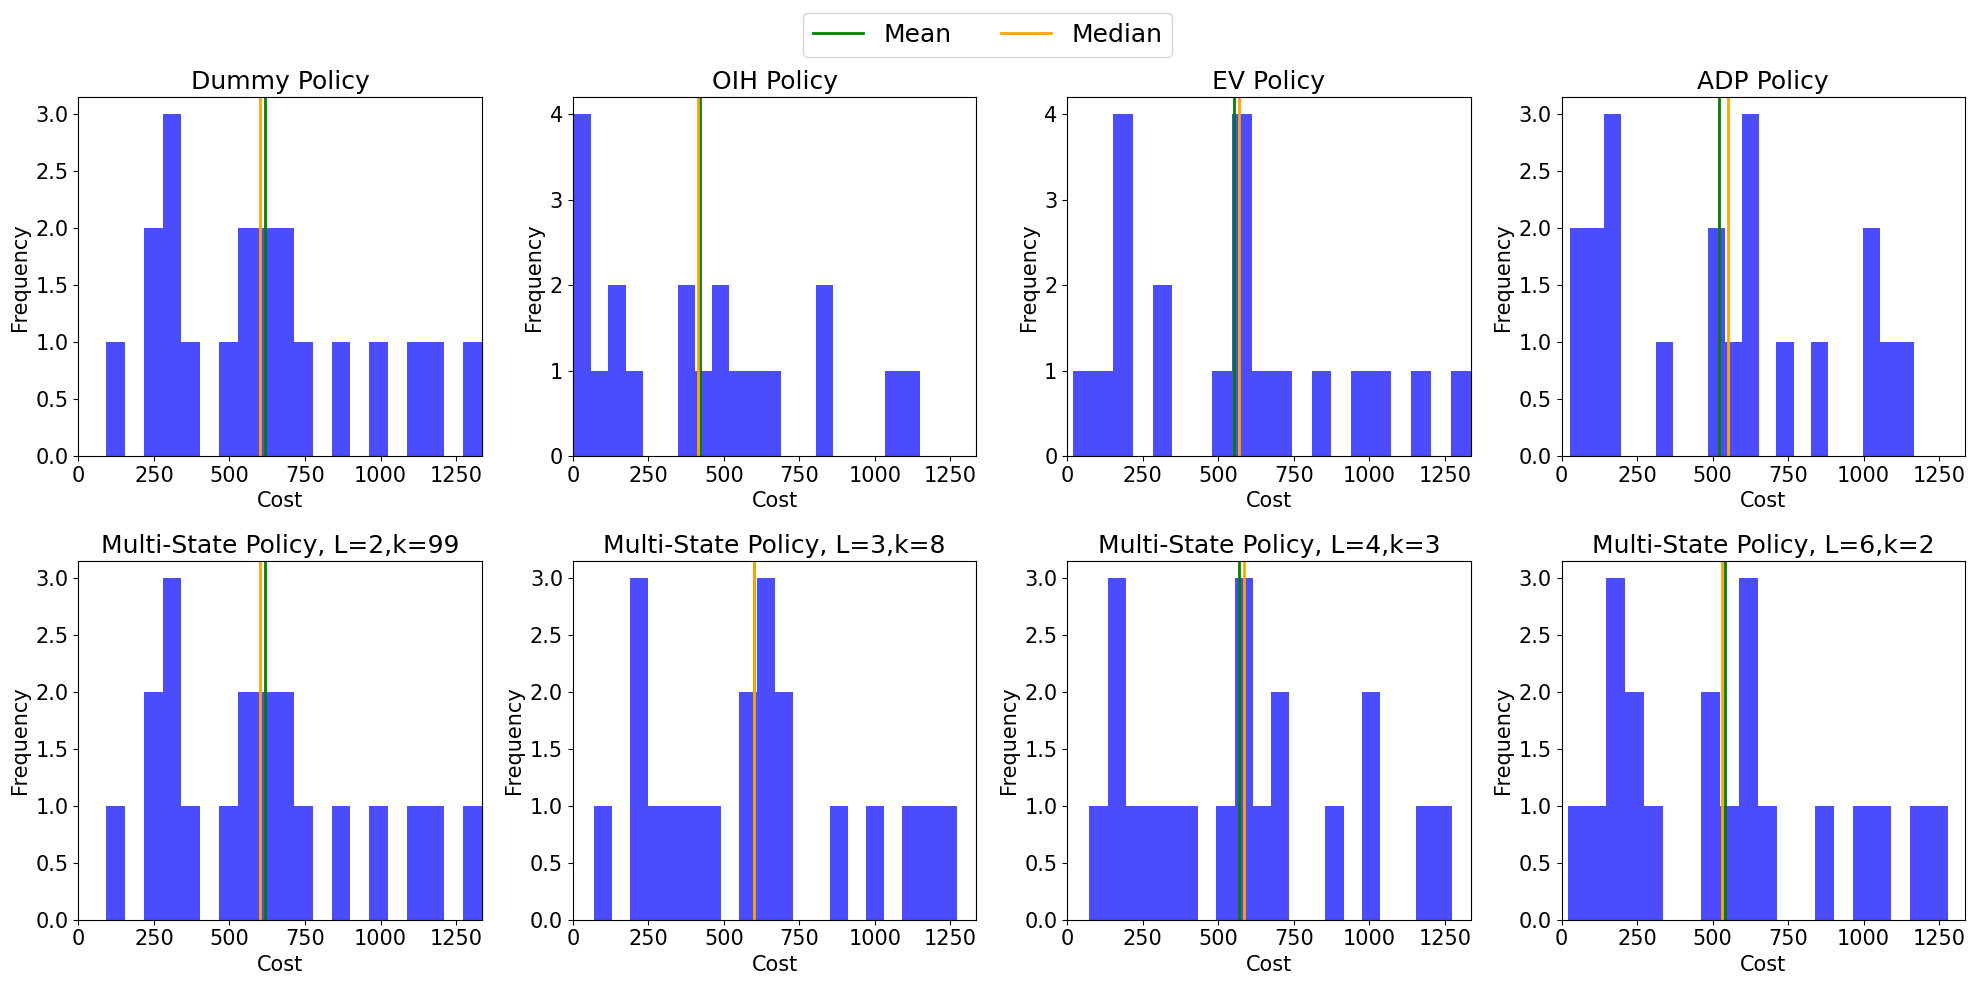

In [17]:
import pickle

# Load the results data from the file
with open("results/results_data.pkl", "rb") as file:
    results_data = pickle.load(file)

# Extract the necessary data
costs_dummy = results_data["costs_dummy"]
costs_oih = results_data["costs_oih"]
costs_ev = results_data["costs_ev"]
costs_adp = results_data["costs_adp"]
results = results_data["results"]

plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Define a common range for the x-axis
common_xlim = (0, max(max(costs_dummy), max(costs_oih), max(costs_ev), max(costs_adp), results.max()))

# Define consistent colors for histograms and lines
hist_color = 'blue'
mean_color = 'green'
median_color = 'orange'

# First row: Dummy, OIH, EV, and ADP policies
for i, (costs, title) in enumerate(zip(
    [costs_dummy, costs_oih, costs_ev, costs_adp],
    ["Dummy Policy", "OIH Policy", "EV Policy", "ADP Policy"]
)):
    axes[0, i].hist(costs, bins=20, color=hist_color, alpha=0.7)
    axes[0, i].axvline(np.mean(costs), color=mean_color, linewidth=2, label='Mean')
    axes[0, i].axvline(np.median(costs), color=median_color, linewidth=2, label='Median')
    axes[0, i].set_title(title)
    axes[0, i].set_xlabel("Cost")
    axes[0, i].set_ylabel("Frequency")
    axes[0, i].set_xlim(common_xlim)

config = ["L=2,k=99", "L=3,k=8", "L=4,k=3", "L=6,k=2"]

# Second row: Multi-state policies for 4 configurations
for i in range(4):
    axes[1, i].hist(results[i, :], bins=20, color=hist_color, alpha=0.7)
    axes[1, i].axvline(np.mean(results[i, :]), color=mean_color, linewidth=2, label='Mean')
    axes[1, i].axvline(np.median(results[i, :]), color=median_color, linewidth=2, label='Median')
    axes[1, i].set_title(f"Multi-State Policy, {config[i]}")
    axes[1, i].set_xlabel("Cost")
    axes[1, i].set_ylabel("Frequency")
    axes[1, i].set_xlim(common_xlim)

# Add a common legend
handles = [
    plt.Line2D([0], [0], color=mean_color, linewidth=2, label='Mean'),
    plt.Line2D([0], [0], color=median_color, linewidth=2, label='Median')
]
fig.legend(handles=handles, loc='upper center', ncol=2, fontsize=18)
plt.tight_layout(rect=[0, 0.00, 1, 0.95])  # Adjust layout to make space for the legend
plt.savefig("figures/policy_comparison.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [24]:
methods = {
    "Dummy Policy": costs_dummy,
    "OIH Policy": costs_oih,
    "EV Policy": costs_ev,
    "ADP Policy": costs_adp,
    "Multi-State Policy (L=2, k=99)": results[0, :],
    "Multi-State Policy (L=3, k=8)": results[1, :],
    "Multi-State Policy (L=4, k=3)": results[2, :],
    "Multi-State Policy (L=6, k=2)": results[3, :]
}

for method, costs in methods.items():
    mean = np.mean(costs)
    std = np.std(costs)
    print(f"{method}: Mean = {mean:.2f}, Std = {std:.2f}")
    

print("------ ordered by mean cost -------")
# Sort the methods by their mean cost
sorted_methods = sorted(methods.items(), key=lambda x: np.mean(x[1]))

# Print the sorted methods with their mean and standard deviation
for method, costs in sorted_methods:
    mean = np.mean(costs)
    std = np.std(costs)
    print(f"{method}: Mean = {mean:.2f}, Std = {std:.2f}")

Dummy Policy: Mean = 618.46, Std = 331.41
OIH Policy: Mean = 421.44, Std = 342.30
EV Policy: Mean = 551.84, Std = 365.79
ADP Policy: Mean = 521.61, Std = 367.42
Multi-State Policy (L=2, k=99): Mean = 618.46, Std = 331.41
Multi-State Policy (L=3, k=8): Mean = 599.51, Std = 336.55
Multi-State Policy (L=4, k=3): Mean = 569.79, Std = 346.07
Multi-State Policy (L=6, k=2): Mean = 542.23, Std = 360.41
------ ordered by mean cost -------
OIH Policy: Mean = 421.44, Std = 342.30
ADP Policy: Mean = 521.61, Std = 367.42
Multi-State Policy (L=6, k=2): Mean = 542.23, Std = 360.41
EV Policy: Mean = 551.84, Std = 365.79
Multi-State Policy (L=4, k=3): Mean = 569.79, Std = 346.07
Multi-State Policy (L=3, k=8): Mean = 599.51, Std = 336.55
Multi-State Policy (L=2, k=99): Mean = 618.46, Std = 331.41
Dummy Policy: Mean = 618.46, Std = 331.41
